# Federated Semantic Segmentation for self-driving cars

## STEP 0 : SETUP PHASE

 ### Installs and imports

In [ ]:
!pip install torchmetrics
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 7.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 17.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.1/189.1 KB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 8.0 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=24898799fa73a7903d18b9e3048dd1ef42e0e35236802782b12244659f06db04
  Stored in directory: /root/.cache/pip/wheels/b7/0a/67/ada2a22079218c75a88361c0782855cc72aebc4d18d0289d05
Successfully built pathtools


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as torch_data
import numpy as np
import matplotlib.pyplot as plt
import random
import torchvision
import logging
import warnings
import math
import json
import wandb

from torchvision import transforms
from torch.backends import cudnn
from torch import from_numpy
from PIL import Image
from torch.utils.data import Subset, DataLoader
from torchvision.io import read_image # importare solo se si usa nella classe Dataset
from torchmetrics.classification import MulticlassJaccardIndex

# ignore/don't display warnings in Python
warnings.resetwarnings()
warnings.simplefilter('ignore')
#warnings.simplefilter('ignore', FutureWarning) FutureWarning, DeprecationWarning, SyntaxWarning, RuntimeWarning...

### Parameters Configuration

In [ ]:
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

PARTITION = 'B' # A or B to choose which dataloader to use
SEED = 42
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 19
if NUM_CLASSES == 19:
  cl19 = True

BATCH_SIZE = 8     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing ***
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 0.05           # The initial Learning Rate ***
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD ***
WEIGHT_DECAY =0.0005  # Regularization, you can keep this at the default ***

NUM_EPOCHS = 10     # Total number of training epochs (iterations over dataset)

# servono per decrementare il lerning rate nel tempo 
STEP_SIZE = 500       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.8          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 20
LOG_FREQUENCY_EPOCH = 3

ROOT_DIR = os.path.join('data', 'Cityscapes')
ROOT_DIR_GTA5 = os.path.join('data', 'GTA5')


#### Data augmentation options

In [ ]:
# data augmentation options
# set as None if a transformation should not be used

RANDOM_HORIZONTAL_FLIP = 0.5
#RANDOM_HORIZONTAL_FLIP = None      #probability of the image being flipped
COLOR_JITTER = (0.2,0.3,0.2,0.2) # (brighteness, contrast, saturation, hue)
#COLOR_JITTER = None
RANDOM_ROTATION = 5              # degree of rotation
#RANDOM_ROTATION = None
#RANDOM_CROP = (512,1024)         # output size of the crop
RANDOM_CROP = None
#RESIZE = (512,1024)              # output size
RESIZE = None
#RANDOM_VERTICAL_FLIP  = 0.3     # probability of the image being flipped
RANDOM_VERTICAL_FLIP = None
CENTRAL_CROP = (512,1024)
#CENTRAL_CROP = (512,1024)
#RANDOM_RESIZE_CROP = (1024,2048)
RANDOM_RESIZE_CROP = None

### Mounting drive and clone FedDrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/AMLproject/

/content/drive/MyDrive/AMLproject


In [ ]:
if not os.path.isdir('./FedDrive'):
  !git clone https://github.com/Erosinho13/FedDrive

from FedDrive.src.modules.bisenetv2 import BiSeNetV2

### Data Augmentation Utility
#### support functions

In [ ]:
import torchvision.transforms.functional as F
import collections
import numbers

_pil_interpolation_to_str = {
    Image.NEAREST: "PIL.Image.NEAREST",
    Image.BILINEAR: "PIL.Image.BILINEAR",
    Image.BICUBIC: "PIL.Image.BICUBIC",
    Image.LANCZOS: "PIL.Image.LANCZOS",
    Image.HAMMING: "PIL.Image.HAMMING",
    Image.BOX: "PIL.Image.BOX",
}

class Compose(object):
    """Composes several transforms together.
    Args:
        transforms (list of ``Transform`` objects): list of transforms to compose.
    """

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, lbl=None):
        if lbl is not None:
            for t in self.transforms:
                img, lbl = t(img, lbl)
            return img, lbl
        else:
            for t in self.transforms:
                img = t(img)
            return img

    def __repr__(self):
        format_string = self.__class__.__name__ + "("
        for t in self.transforms:
            format_string += "\n"
            format_string += "    {0}".format(t)
        format_string += "\n)"
        return format_string

class RandomCrop(object):
    """Crop the given PIL Image at a random location.
    Args:
        size (sequence or int): Desired output size of the crop. If size is an
            int instead of sequence like (h, w), a square crop (size, size) is
            made.
        padding (int or sequence, optional): Optional padding on each border
            of the image. Default is 0, i.e no padding. If a sequence of length
            4 is provided, it is used to pad left, top, right, bottom borders
            respectively.
        pad_if_needed (boolean): It will pad the image if smaller than the
            desired size to avoid raising an exception.
    """

    def __init__(self, size, padding=0, pad_if_needed=False):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size
        self.padding = padding
        self.pad_if_needed = pad_if_needed

    @staticmethod
    def get_params(img, output_size):
        """Get parameters for ``crop`` for a random crop.
        Args:
            img (PIL Image): Image to be cropped.
            output_size (tuple): Expected output size of the crop.
        Returns:
            tuple: params (i, j, h, w) to be passed to ``crop`` for random crop.
        """

        w, h = img.size()[1:]
        th, tw = output_size
        if w == tw and h == th:
            return 0, 0, h, w

        i = random.randint(0, h - th)
        j = random.randint(0, w - tw)
        return i, j, th, tw

    def __call__(self, img, lbl=None):
        """
        Args:
            img (PIL Image): Image to be cropped.
            lbl (PIL Image): Label to be cropped.
        Returns:
            PIL Image: Cropped image.
            PIL Image: Cropped label.
        """

        if lbl is None:
            if self.padding > 0:
                img = F.pad(img, self.padding)
            # pad the width if needed
            if self.pad_if_needed and img.size[0] < self.size[1]:
                img = F.pad(img, padding=int((1 + self.size[1] - img.size[0]) / 2))
            # pad the height if needed
            if self.pad_if_needed and img.size[1] < self.size[0]:
                img = F.pad(img, padding=int((1 + self.size[0] - img.size[1]) / 2))

            i, j, h, w = self.get_params(img, self.size)

            return F.crop(img, i, j, h, w)

        else:
            assert (
                img.size()[1:] == lbl.size()[1:]
            ), "size of img and lbl should be the same. %s, %s" % (img.size, lbl.size)
            if self.padding > 0:
                img = F.pad(img, self.padding)
                lbl = F.pad(lbl, self.padding)

            # pad the width if needed
            if self.pad_if_needed and img.size[0] < self.size[1]:
                img = F.pad(img, padding=int((1 + self.size[1] - img.size[0]) / 2))
                lbl = F.pad(
                    lbl, padding=int((1 + self.size[1] - lbl.size[0]) / 2), fill=255
                )

            # pad the height if needed
            if self.pad_if_needed and img.size[1] < self.size[0]:
                img = F.pad(img, padding=int((1 + self.size[0] - img.size[1]) / 2))
                lbl = F.pad(
                    lbl, padding=int((1 + self.size[0] - lbl.size[1]) / 2), fill=255
                )

            i, j, h, w = self.get_params(img, self.size)
            return F.crop(img, i, j, h, w), F.crop(lbl, i, j, h, w)

    def __repr__(self):
        return self.__class__.__name__ + "(size={0}, padding={1})".format(
            self.size, self.padding
        )


class Resize(object):
    """Resize the input PIL Image to the given size.
    Args:
        size (sequence or int): Desired output size. If size is a sequence like
            (h, w), output size will be matched to this. If size is an int,
            smaller edge of the image will be matched to this number.
            i.e, if height > width, then image will be rescaled to
            (size * height / width, size)
        interpolation (int, optional): Desired interpolation. Default is
            ``PIL.Image.BILINEAR``
    """

    def __init__(self, size, interpolation=Image.BILINEAR):
        assert isinstance(size, int) or (
            isinstance(size, collections.abc.Iterable) and len(size) == 2
        )
        self.size = size
        self.interpolation = interpolation

    def __call__(self, img, lbl=None):
        """
        Args:
            img (PIL Image): Image to be scaled.
        Returns:
            PIL Image: Rescaled image.
        """
        if lbl is not None:
            return F.resize(img, self.size, self.interpolation), F.resize(
                lbl, self.size, Image.NEAREST
            )
        else:
            return F.resize(img, self.size, self.interpolation)

    def __repr__(self):
        interpolate_str = _pil_interpolation_to_str[self.interpolation]
        return self.__class__.__name__ + "(size={0}, interpolation={1})".format(
            self.size, interpolate_str
        )
class RandomRotation(object):
    """Rotate the image by angle.
    Args:
        degrees (sequence or float or int): Range of degrees to select from.
            If degrees is a number instead of sequence like (min, max), the range of degrees
            will be (-degrees, +degrees).
        resample ({PIL.Image.NEAREST, PIL.Image.BILINEAR, PIL.Image.BICUBIC}, optional):
            An optional resampling filter.
            See http://pillow.readthedocs.io/en/3.4.x/handbook/concepts.html#filters
            If omitted, or if the image has mode "1" or "P", it is set to PIL.Image.NEAREST.
        expand (bool, optional): Optional expansion flag.
            If true, expands the output to make it large enough to hold the entire rotated image.
            If false or omitted, make the output image the same size as the input image.
            Note that the expand flag assumes rotation around the center and no translation.
        center (2-tuple, optional): Optional center of rotation.
            Origin is the upper left corner.
            Default is the center of the image.
    """

    def __init__(self, degrees, resample=False, expand=False, center=None):
        if isinstance(degrees, numbers.Number):
            if degrees < 0:
                raise ValueError("If degrees is a single number, it must be positive.")
            self.degrees = (-degrees, degrees)
        else:
            if len(degrees) != 2:
                raise ValueError("If degrees is a sequence, it must be of len 2.")
            self.degrees = degrees

        self.resample = resample
        self.expand = expand
        self.center = center

    @staticmethod
    def get_params(degrees):
        """Get parameters for ``rotate`` for a random rotation.
        Returns:
            sequence: params to be passed to ``rotate`` for random rotation.
        """
        angle = random.uniform(degrees[0], degrees[1])

        return angle

    def __call__(self, img, lbl):
        """
            img (PIL Image): Image to be rotated.
            lbl (PIL Image): Label to be rotated.
        Returns:
            PIL Image: Rotated image.
            PIL Image: Rotated label.
        """

        angle = self.get_params(self.degrees)
        if lbl is not None:
            return F.rotate(
                img, angle, self.resample, self.expand, self.center
            ), F.rotate(lbl, angle, self.resample, self.expand, self.center)
        else:
            return F.rotate(img, angle, self.resample, self.expand, self.center)

    def __repr__(self):
        format_string = self.__class__.__name__ + "(degrees={0}".format(self.degrees)
        format_string += ", resample={0}".format(self.resample)
        format_string += ", expand={0}".format(self.expand)
        if self.center is not None:
            format_string += ", center={0}".format(self.center)
        format_string += ")"
        return format_string

class RandomHorizontalFlip(object):
    """Horizontally flip the given PIL Image randomly with a given probability.
    Args:
        p (float): probability of the image being flipped. Default value is 0.5
    """

    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, img, lbl=None):
        """
        Args:
            img (PIL Image): Image to be flipped.
        Returns:
            PIL Image: Randomly flipped image.
        """
        if random.random() < self.p:
            if lbl is not None:
                return F.hflip(img), F.hflip(lbl)
            else:
                return F.hflip(img)
        if lbl is not None:
            return img, lbl
        else:
            return img

    def __repr__(self):
        return self.__class__.__name__ + "(p={})".format(self.p)


class RandomVerticalFlip(object):
    """Vertically flip the given PIL Image randomly with a given probability.
    Args:
        p (float): probability of the image being flipped. Default value is 0.5
    """

    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, img, lbl):
        """
        Args:
            img (PIL Image): Image to be flipped.
            lbl (PIL Image): Label to be flipped.
        Returns:
            PIL Image: Randomly flipped image.
            PIL Image: Randomly flipped label.
        """
        if random.random() < self.p:
            if lbl is not None:
                return F.vflip(img), F.vflip(lbl)
            else:
                return F.vflip(img)
        if lbl is not None:
            return img, lbl
        else:
            return img

    def __repr__(self):
        return self.__class__.__name__ + "(p={})".format(self.p)

class ColorJitter(object):
    """Randomly change the brightness, contrast and saturation of an image.
    Args:
        brightness (float or tuple of float (min, max)): How much to jitter brightness.
            brightness_factor is chosen uniformly from [max(0, 1 - brightness), 1 + brightness]
            or the given [min, max]. Should be non negative numbers.
        contrast (float or tuple of float (min, max)): How much to jitter contrast.
            contrast_factor is chosen uniformly from [max(0, 1 - contrast), 1 + contrast]
            or the given [min, max]. Should be non negative numbers.
        saturation (float or tuple of float (min, max)): How much to jitter saturation.
            saturation_factor is chosen uniformly from [max(0, 1 - saturation), 1 + saturation]
            or the given [min, max]. Should be non negative numbers.
        hue (float or tuple of float (min, max)): How much to jitter hue.
            hue_factor is chosen uniformly from [-hue, hue] or the given [min, max].
            Should have 0<= hue <= 0.5 or -0.5 <= min <= max <= 0.5.
    """

    def __init__(self, brightness=0, contrast=0, saturation=0, hue=0):
        self.brightness = self._check_input(brightness, "brightness")
        self.contrast = self._check_input(contrast, "contrast")
        self.saturation = self._check_input(saturation, "saturation")
        self.hue = self._check_input(
            hue, "hue", center=0, bound=(-0.5, 0.5), clip_first_on_zero=False
        )

    def _check_input(
        self, value, name, center=1, bound=(0, float("inf")), clip_first_on_zero=True
    ):
        if isinstance(value, numbers.Number):
            if value < 0:
                raise ValueError(
                    "If {} is a single number, it must be non negative.".format(name)
                )
            value = [center - value, center + value]
            if clip_first_on_zero:
                value[0] = max(value[0], 0)
        elif isinstance(value, (tuple, list)) and len(value) == 2:
            if not bound[0] <= value[0] <= value[1] <= bound[1]:
                raise ValueError("{} values should be between {}".format(name, bound))
        else:
            raise TypeError(
                "{} should be a single number or a list/tuple with lenght 2.".format(
                    name
                )
            )

        # if value is 0 or (1., 1.) for brightness/contrast/saturation
        # or (0., 0.) for hue, do nothing
        if value[0] == value[1] == center:
            value = None
        return value

    @staticmethod
    def get_params(brightness, contrast, saturation, hue):
        """Get a randomized transform to be applied on image.
        Arguments are same as that of __init__.
        Returns:
            Transform which randomly adjusts brightness, contrast and
            saturation in a random order.
        """
        transforms = []

        if brightness is not None:
            brightness_factor = random.uniform(brightness[0], brightness[1])
            transforms.append(
                Lambda(lambda img: F.adjust_brightness(img, brightness_factor))
            )

        if contrast is not None:
            contrast_factor = random.uniform(contrast[0], contrast[1])
            transforms.append(
                Lambda(lambda img: F.adjust_contrast(img, contrast_factor))
            )

        if saturation is not None:
            saturation_factor = random.uniform(saturation[0], saturation[1])
            transforms.append(
                Lambda(lambda img: F.adjust_saturation(img, saturation_factor))
            )

        if hue is not None:
            hue_factor = random.uniform(hue[0], hue[1])
            transforms.append(Lambda(lambda img: F.adjust_hue(img, hue_factor)))

        random.shuffle(transforms)
        transform = Compose(transforms)

        return transform

    def __call__(self, img, lbl=None):
        """
        Args:
            img (PIL Image): Input image.
        Returns:
            PIL Image: Color jittered image.
        """
        transform = self.get_params(
            self.brightness, self.contrast, self.saturation, self.hue
        )
        if lbl is not None:
            return transform(img), lbl
        else:
            return transform(img)

    def __repr__(self):
        format_string = self.__class__.__name__ + "("
        format_string += "brightness={0}".format(self.brightness)
        format_string += ", contrast={0}".format(self.contrast)
        format_string += ", saturation={0}".format(self.saturation)
        format_string += ", hue={0})".format(self.hue)
        return format_string


class Lambda(object):
    """Apply a user-defined lambda as a transform.
    Args:
        lambd (function): Lambda/function to be used for transform.
    """

    def __init__(self, lambd):
        assert callable(lambd), repr(type(lambd).__name__) + " object is not callable"
        self.lambd = lambd

    def __call__(self, img, lbl=None):
        if lbl is not None:
            return self.lambd(img), self.lambd(lbl)
        else:
            return self.lambd(img)

    def __repr__(self):
        return self.__class__.__name__ + "()"

class CenterCrop(object):
    """Crops the given PIL Image at the center.
    Args:
        size (sequence or int): Desired output size of the crop. If size is an
            int instead of sequence like (h, w), a square crop (size, size) is
            made.
    """

    def __init__(self, size):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size

    def __call__(self, img, lbl=None):
        """
        Args:
            img (PIL Image): Image to be cropped.
        Returns:
            PIL Image: Cropped image.
        """
        if lbl is not None:
            return F.center_crop(img, self.size), F.center_crop(lbl, self.size)
        else:
            return F.center_crop(img, self.size)

    def __repr__(self):
        return self.__class__.__name__ + f'(size={self.size})'

class RandomResizedCrop(object):
    """Crop the given PIL Image to random size and aspect ratio.
    A crop of random size (default: of 0.08 to 1.0) of the original size and a random
    aspect ratio (default: of 3/4 to 4/3) of the original aspect ratio is made. This crop
    is finally resized to given size.
    This is popularly used to train the Inception networks.
    Args:
        size: expected output size of each edge
        scale: range of size of the origin size cropped
        ratio: range of aspect ratio of the origin aspect ratio cropped
        interpolation: Default: PIL.Image.BILINEAR
    """

    def __init__(self, size, scale=(0.08, 1.0), ratio=(3. / 4., 4. / 3.), interpolation=Image.BILINEAR):
        if isinstance(size, tuple):
            self.size = size
        else:
            self.size = (size, size)
        if (scale[0] > scale[1]) or (ratio[0] > ratio[1]):
            warnings.warn("range should be of kind (min, max)")

        self.interpolation = interpolation
        self.scale = scale
        self.ratio = ratio

    @staticmethod
    def get_params(img, scale, ratio):
        """Get parameters for ``crop`` for a random sized crop.
        Args:
            img (PIL Image): Image to be cropped.
            scale (tuple): range of size of the origin size cropped
            ratio (tuple): range of aspect ratio of the origin aspect ratio cropped
        Returns:
            tuple: params (i, j, h, w) to be passed to ``crop`` for a random
                sized crop.
        """
        area = img.size[0] * img.size[1]

        for attempt in range(10):
            target_area = random.uniform(*scale) * area
            log_ratio = (math.log(ratio[0]), math.log(ratio[1]))
            aspect_ratio = math.exp(random.uniform(*log_ratio))

            w = int(round(math.sqrt(target_area * aspect_ratio)))
            h = int(round(math.sqrt(target_area / aspect_ratio)))

            if w <= img.size[0] and h <= img.size[1]:
                i = random.randint(0, img.size[1] - h)
                j = random.randint(0, img.size[0] - w)
                return i, j, h, w

        # Fallback to central crop
        in_ratio = img.size[0] / img.size[1]
        if (in_ratio < min(ratio)):
            w = img.size[0]
            h = int(round(w / min(ratio)))
        elif (in_ratio > max(ratio)):
            h = img.size[1]
            w = int(round(h * max(ratio)))
        else:  # whole image
            w = img.size[0]
            h = img.size[1]
        i = (img.size[1] - h) // 2
        j = (img.size[0] - w) // 2
        return i, j, h, w

    def __call__(self, img, lbl=None):
        """
        Args:
            img (PIL Image): Image to be cropped and resized.
        Returns:
            PIL Image: Randomly cropped and resized image.
        """
        i, j, h, w = self.get_params(img, self.scale, self.ratio)
        if lbl is not None:
            return F.resized_crop(img, i, j, h, w, self.size, self.interpolation), \
                   F.resized_crop(lbl, i, j, h, w, self.size, Image.NEAREST)
        else:
            return F.resized_crop(img, i, j, h, w, self.size, self.interpolation)

    def __repr__(self):
        interpolate_str = _pil_interpolation_to_str[self.interpolation]
        format_string = self.__class__.__name__ + '(size={0}'.format(self.size)
        format_string += ', scale={0}'.format(tuple(round(s, 4) for s in self.scale))
        format_string += ', ratio={0}'.format(tuple(round(r, 4) for r in self.ratio))
        format_string += ', interpolation={0})'.format(interpolate_str)
        return format_string



### Utilits

In [ ]:
# https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py

colors = [
        [128, 64, 128],
        [244, 35, 232],
        [70, 70, 70],
        [102, 102, 156],
        [190, 153, 153],
        [153, 153, 153],
        [250, 170, 30],
        [220, 220, 0],
        [107, 142, 35],
        [152, 251, 152],
        [0, 130, 180],
        [220, 20, 60],
        [255, 0, 0],
        [0, 0, 142],
        [0, 0, 70],
        [0, 60, 100],
        [0, 80, 100],
        [0, 0, 230],
        [119, 11, 32]    
        ]

label_colours = dict(zip(range(NUM_CLASSES), colors))

def decode_segmap(temp):
    #convert gray scale to color
    #print colored map
    temp=temp.numpy()
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(0, NUM_CLASSES):
        r[temp == l] = label_colours[l][0]
        g[temp == l] = label_colours[l][1]
        b[temp == l] = label_colours[l][2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:, :, 0] = r / 255.0
    rgb[:, :, 1] = g / 255.0
    rgb[:, :, 2] = b / 255.0
    return rgb

def validation_plot(net, val_dataloader, n_image):
  net = net.to(DEVICE)
  net.train(False)
  rows = 1
  columns = 3
  for b, (imgs, targets) in enumerate(val_dataloader):
      if b == n_image: break
      #i = random.randint(BATCH_SIZE)
      imgsfloat = imgs.to(DEVICE, dtype=torch.float32)
      outputs = net(imgsfloat)
      _, preds = torch.max(outputs.data, 1)
      # Added in order to use the decode_segmap function
      preds = preds.cpu() # or equally preds = preds.to('cpu')

      # pick the first image of each batch
      print(imgs[0].shape,targets[0].shape)
      print("img:", imgs[0].squeeze().shape, " target:",targets[0].squeeze().shape)
      print("pred:", preds.shape)

      figure = plt.figure(figsize=(10,20))
      figure.add_subplot(rows, columns,1)
      plt.imshow(imgs[0].permute((1, 2, 0)).squeeze())
      plt.axis('off')
      plt.title("Image")

      figure.add_subplot(rows, columns,2)
      plt.imshow(decode_segmap(targets[0].permute((1, 2, 0)).squeeze()))
      plt.axis('off')
      plt.title("Groundtruth")

      figure.add_subplot(rows, columns,3)
      plt.imshow(decode_segmap(preds[0].squeeze()))
      plt.axis('off')
      plt.title("Prediction")
      plt.show()
  return

  from torchmetrics.classification import MulticlassJaccardIndex

def compute_moiu(net, val_dataloader):
  net = net.to(DEVICE)
  net.train(False) # Set Network to evaluation mode
  jaccard = MulticlassJaccardIndex( num_classes=NUM_CLASSES,ignore_index=255).to(DEVICE)

  jacc = 0
  count = 0
  for images, labels in val_dataloader:
    images = images.to(DEVICE, dtype=torch.float32)
    labels = labels.to(DEVICE, dtype=torch.long)

    # Forward Pass
    outputs = net(images)
    # Get predictions
    _, preds = torch.max(outputs.data, 1)

    # Update Corrects
    jacc += jaccard(preds, labels.squeeze())
    count += 1

  # Calculate Accuracy
  metric = jacc.item() / count
  net.train(True)
  return metric


## STEP 1 : GENERATING DATASET FOR CITYSCAPE

### Dataset Preprocessing
Needed for the creation of partition A

In [ ]:
if 'train_A.txt' not in os.listdir(ROOT_DIR) or 'test_A.txt' not in os.listdir(ROOT_DIR):

  random.seed(42)
  IMAGES_FINAL = 'leftImg8bit'
  TARGET_FINAL = 'gtFine_labelIds'

  with open(os.path.join(ROOT_DIR, 'train.txt'), 'r') as ft:
      lines_train = ft.readlines()
  with open(os.path.join(ROOT_DIR,'val.txt'),'r') as fv:
      lines_val = fv.readlines()

  lines = lines_train + lines_val
  images = [(l.split("/")[0], l.strip().split("/")[1], l.strip().split("/")[1].replace(IMAGES_FINAL,TARGET_FINAL)) for l in lines]

  city_dic = {}

  for i in images:
      if i[0] not in city_dic:
        city_dic[i[0]] =  []
        city_dic[i[0]].append(tuple(i[1:]))
      else:
        city_dic[i[0]].append(tuple(i[1:]))
  test_img = []
  train_img = []


  for c in city_dic.values():
      s = random.sample(c,2)
      test_img += s
      train_img += c
      for img in s:
          train_img.remove(img)

  # save the split
  with open(os.path.join(ROOT_DIR,"test_A.txt"),"w") as f:
      for img in test_img:
        f.write(img[0]+"@"+img[1]+"\n")  

  with open(os.path.join(ROOT_DIR,"train_A.txt"),"w") as f:
      for img in train_img:
        f.write(str(img[0])+"@"+img[1]+"\n")   



### Dataset Partition A
- Test partition: 2 random images from each city
- Train partition: the remaining images

In [ ]:
class CityscapesPartA(torch_data.Dataset):
  

  '''
  image path: data/Cityscapes/images/name_leftImg8bit.png
  taget path: data/Cityscapes/labels/name_gtFine_labelIds.png
  '''

  def __init__(self, root, train=True, transform=None, cl19=False):

      eval_classes = [7, 8, 11, 12, 13, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33]
      self.root = root

      if train:
        split = 'train_A.txt'
      else:
        split = 'test_A.txt'
      
      with open(os.path.join(root,split), "r") as f:
        lines = f.readlines()

      
      # manipulate each file row in order to obtain the correct path       
      self.paths_images = [l.strip().split('@')[0] for l in lines]
      self.paths_tagets = [l.strip().split('@')[1] for l in lines]

      self.len = len(self.paths_images)
      self.transform = transform

      if cl19:
        classes = eval_classes
        mapping = np.zeros((256,), dtype=np.int64) + 255
        for i, cl in enumerate(classes):
          mapping[cl] = i
        self.target_transform = lambda x: from_numpy(mapping[x])

  def __getitem__(self, index):
      """
      Args:
          index (int): Index
      Returns:
          tuple: (image, target) where target is the label of segmentation.
      """

      # # using read_image
      img = read_image(os.path.join(self.root,"images",self.paths_images[index]))
      target = read_image(os.path.join(self.root,"labels",self.paths_tagets[index]))
      if self.transform:
        img, target = self.transform(img, target)

      if self.target_transform:
        target = self.target_transform(target)

      return img, target # output: Tensor[image_channels, image_height, image_width]

      # # using Image.open + np.array
      # img = Image.open(os.path.join(self.root,"images",self.paths_images[index]))
      # target = Image.open(os.path.join(self.root,"labels",self.paths_tagets[index]))
      
      # return np.array(img), np.array(target) # output: Tensor[image_height, image_width, image_channels]
      

  def __len__(self):
      return self.len

### Dataset Partition B
- Test partition: the list of images in val.txt
- Train partition: the list of images in train.txt


In [ ]:
class CityscapesPartB(torch_data.Dataset):

  '''
  image path: data/Cityscapes/images/name_leftImg8bit.png
  taget path: data/Cityscapes/labels/name_gtFine_labelIds.png
  '''

  def __init__(self, root, train=True, transform=None, cl19=False):
      eval_classes = [7, 8, 11, 12, 13, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33]
      IMAGES_FINAL = 'leftImg8bit'
      TARGET_FINAL = 'gtFine_labelIds'
      if train:
        split = 'train.txt'
      else:
        split = 'val.txt'
      
      self.root = root
      with open(os.path.join(root,split), "r") as f:
        lines = f.readlines()

      # manipulate each file row in order to obtain the correct path 
      self.paths_images = [l.strip().split('/')[1] for l in lines]
      self.paths_tagets = [l.replace(IMAGES_FINAL, TARGET_FINAL) for l in self.paths_images]

      self.len = len(self.paths_images)
      self.transform = transform
      self.target_transform = None

      if cl19:
        classes = eval_classes
        mapping = np.zeros((256,), dtype=np.int64) + 255
        for i, cl in enumerate(classes):
          mapping[cl] = i
        self.target_transform = lambda x: from_numpy(mapping[x])

  def __getitem__(self, index):
      """
      Args:
          index (int): Index
      Returns:
          tuple: (image, target) where target is the label of segmentation.
      """

      ## using read_image
      img = read_image(os.path.join(self.root,"images",self.paths_images[index]))
      target = read_image(os.path.join(self.root,"labels",self.paths_tagets[index]))
      if self.transform:
        img, target = self.transform(img, target)

      if self.target_transform:
          target = self.target_transform(target)

      return img, target # output: Tensor[image_channels, image_height, image_width]

      # # using Image.open + np.array
      # img = Image.open(os.path.join(self.root,"images",self.paths_images[index]))
      # target = Image.open(os.path.join(self.root,"labels",self.paths_tagets[index]))
      # if self.transform:
      #   img, target = self.transform(img, target)

      # if self.target_transform:
      #     target = self.target_transform(target)
      # return img,target
      # return np.array(img), np.array(target) # output: Tensor[image_height, image_width, image_channels]
      
      
  def __len__(self):
      return self.len

### Dataloader test

Dataset dimension:  250
torch.Size([3, 512, 1024]) torch.Size([1, 512, 1024])
img type: <class 'torch.Tensor'>  target: <class 'torch.Tensor'>
img: torch.Size([3, 512, 1024])  target: torch.Size([512, 1024])


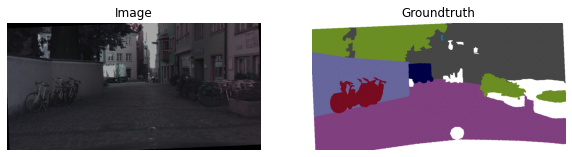

In [ ]:
# import transform as Tc
# transform = Tc.Compose([Tc.Resize(size=(512, 1024)),Tc.RandomHorizontalFlip(),Tc.ColorJitter()])

#trasform = torch.nn.Sequential(
#    Resize(),
#)

#transform = Compose([Resize([512,1024]),RandomHorizontalFlip(0.5),ColorJitter(0.5,0.4,0.5,0.5),RandomRotation(10)])

train_dataset = CityscapesPartB(root=ROOT_DIR, train=False, transform=transform,cl19 = True)
print("Dataset dimension: ", len(train_dataset))
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)

rows = 1
columns = 2
for imgs, targets in train_dataloader:
    print(imgs[0].shape,targets[0].shape)

    figure = plt.figure(figsize=(10,20))
    figure.add_subplot(rows, columns,1)
    print("img type:",type(imgs[0]), " target:",type(targets[0]))
    print("img:", imgs[0].squeeze().shape, " target:",targets[0].squeeze().shape)
    #print("img:", imgs[0], "target:",targets[0])
    # used with tensor
    #print("img:", imgs[0].permute((1, 2, 0)).shape, " target:",targets[0].permute((1, 2, 0)).shape)
    plt.imshow(imgs[0].permute((1, 2, 0)).squeeze())
    # used with np.array
    #plt.imshow(imgs[0].squeeze())
    plt.axis('off')
    plt.title("Image")
    figure.add_subplot(rows, columns,2)
    # used with tensor
    plt.imshow(decode_segmap(targets[0].permute((1, 2, 0)).squeeze()))
    # used with np.array
    #plt.imshow(targets[0].squeeze())
    plt.axis('off')
    plt.title("Groundtruth")
    plt.show()
    break

## STEP 2 : CENTRALIZED BASELINE
### TRAIN USING BiSeNet

### Transformers

In [ ]:
from drive.MyDrive.AMLproject import transform as T

transformers = []
if RANDOM_HORIZONTAL_FLIP is not None:
    transformers.append(T.RandomHorizontalFlip(RANDOM_HORIZONTAL_FLIP))
if COLOR_JITTER is not None:
    transformers.append(T.ColorJitter(*COLOR_JITTER))
if RANDOM_ROTATION is not None:
    transformers.append(T.RandomRotation(RANDOM_ROTATION))
if RANDOM_CROP is not None:
    transformers.append(T.RandomCrop(RANDOM_CROP))
if RANDOM_VERTICAL_FLIP is not None:
    transformers.append(T.RandomVerticalFlip(RANDOM_VERTICAL_FLIP))
if CENTRAL_CROP is not None:
    transformers.append(T.CenterCrop(CENTRAL_CROP))
if RANDOM_RESIZE_CROP is not None:
    transformers.append(T.RandomResizedCrop(RANDOM_RESIZE_CROP))
if RESIZE is not None:
  transformers.append(T.Resize(RESIZE))

transform = Compose(transformers)
#transform = Compose([RandomHorizontalFlip(0.4), ColorJitter(0.1,0.4,0.3,0.3),RandomRotation(5),RandomCrop((512,1024)),Resize((512,1024))])


### transformers test

In [ ]:
from PIL import Image

with Image.open(ROOT_DIR+"/images/darmstadt_000018_000019_leftImg8bit.png") as img:
  with Image.open(ROOT_DIR+"/labels/darmstadt_000018_000019_gtFine_labelIds.png") as lbl:
    print(f"type : {type(img)}")
    print(f"img size : {img.size}")
    print(f"lbl size : {lbl.size}")
    for t in transformers:
      print(str(t))
      img,lbl = t(img,lbl)
      img.show()

### Setup for Wandb

In [ ]:
wandb.login()

transformer_dictionary = {
    "random-horizontal-flip":RANDOM_HORIZONTAL_FLIP,
    "color-jitter":COLOR_JITTER,
    "random-rotation":RANDOM_ROTATION,
    "random-crop":RANDOM_CROP,
    "random-vertical-flip":RANDOM_VERTICAL_FLIP,
    "central-crop":CENTRAL_CROP,
    "random-resized-crop":RANDOM_RESIZE_CROP,
    "resize":RESIZE,
    }

config = {
        "batch_size": BATCH_SIZE,
        "lr": LR,
        "momentum": MOMENTUM,
        "weight_decay": WEIGHT_DECAY,
        "num_epochs": NUM_EPOCHS,
        "step_size": STEP_SIZE,
        "gamma": GAMMA,
        "transformers": transformer_dictionary,
    }
name = f"Step_2_{PARTITION}_lr{LR}_bs{BATCH_SIZE}_e{NUM_EPOCHS}"
wandb.init(
    project = "AML-Project-2023",
    entity = "aml-project2023",
    config = config,
    name = name,
)

### Choosing Dataset partitions and creating Dataloader

In [ ]:
if PARTITION == 'A':
    train_dataset = CityscapesPartA(root=ROOT_DIR, train=True, transform=transform,cl19 = True)
elif PARTITION == 'B':
    train_dataset = CityscapesPartB(root=ROOT_DIR, train=True, transform=transform,cl19 = True)
else:
    print("no such dataset")



In [ ]:
print(f"Dataset dimension: {len(train_dataset)}")
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)

Dataset dimension: 500


### Training

In [ ]:
model = BiSeNetV2(NUM_CLASSES, output_aux=False, pretrained=True)

criterion = nn.CrossEntropyLoss(ignore_index= 255) 
parameters_to_optimize = model.parameters()
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

In [ ]:
model = model.to(DEVICE)

cudnn.benchmark # Calling this optimizes runtime

losses = []
losses_val = []
epochs = []

wandb.watch(model, log='all')

current_step = 0
# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
  print('Starting epoch {}/{}'.format(epoch+1, NUM_EPOCHS))
  epochs.append(epoch+1)

  # Iterate over the dataset
  for images, labels in train_dataloader:

    images = images.to(DEVICE, dtype=torch.float32)
    labels = labels.to(DEVICE, dtype=torch.long)
    #print("images:",images.shape,"labels:",labels.shape)

    model.train()
    optimizer.zero_grad() 

    predictions = model(images)
    #print("predictions:",predictions.shape,"labels:",labels.shape)
    loss = criterion(predictions, labels.squeeze())

    #wandb.log({"train/loss":loss})
    
    # Log loss
    if current_step % LOG_FREQUENCY == 0:
      print('Step {}, Loss {}'.format(current_step, loss.item()))
      wandb.log({"train/loss": loss})
    # Compute gradients for each layer and update weights
    loss.backward()
    optimizer.step()

    current_step += 1



Starting epoch 1/10
Step 0, Loss 3.3447206020355225
Step 20, Loss 1.2104783058166504
Step 40, Loss 0.8649155497550964
Step 60, Loss 0.8832752704620361
Starting epoch 2/10
Step 80, Loss 0.7347411513328552
Step 100, Loss 0.5909948945045471
Step 120, Loss 0.7200568914413452
Starting epoch 3/10
Step 140, Loss 0.5853251218795776
Step 160, Loss 0.60515296459198
Step 180, Loss 0.4493062496185303
Starting epoch 4/10
Step 200, Loss 0.42576777935028076
Step 220, Loss 0.6353332996368408
Step 240, Loss 0.5093101859092712
Starting epoch 5/10
Step 260, Loss 0.4316934645175934
Step 280, Loss 0.46796098351478577
Step 300, Loss 0.4263564348220825
Starting epoch 6/10
Step 320, Loss 0.39290401339530945
Step 340, Loss 0.46817710995674133
Step 360, Loss 0.4223383367061615
Starting epoch 7/10
Step 380, Loss 0.3321193754673004
Step 400, Loss 0.602239191532135
Step 420, Loss 0.6007750630378723
Starting epoch 8/10
Step 440, Loss 0.43334731459617615
Step 460, Loss 0.36275041103363037
Step 480, Loss 0.5179175138

### Validation
#### choose dataset partition and create Dataloader

In [ ]:
if PARTITION == 'A':
    val_dataset = CityscapesPartA(root=ROOT_DIR, train=False, transform=transform,cl19 = True)
elif PARTITION == 'B':
    val_dataset = CityscapesPartB(root=ROOT_DIR, train=False, transform=transform,cl19 = True)
else:
    print("no such dataset")

In [ ]:
print("Dataset dimension: ", len(val_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)

Dataset dimension:  250


#### print output of validation step and calculate MIOU

In [ ]:
validation_plot(net= model, val_dataloader=val_dataloader, n_image=20)
torch.cuda.empty_cache()

In [ ]:
miou = compute_moiu(net=model, val_dataloader=val_dataloader)
print('Validation MIoU: {}'.format(miou))
wandb.log({"val/miou":miou})
wandb.finish()

Validation MIoU: 0.3131675104941091


train/loss,█▃▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁
val/miou,▁
train/loss,0.37066
val/miou,0.31317


### Save the trained model

In [ ]:
path1 = './state_dict_model_trained.pth'
path2 = './model_trained.pth'
torch.save(model.state_dict(), path1)
#torch.save(model, path2)

## STEP 3 : FEDERATED + SEMANTIC SEGMENTATION


### Setup

In [ ]:
PARTITION = 'A' # 'A' or 'B'
SPLIT = 2 # 1 or 2 // 1 = Uniform : 2 = Heterogenous
MAX_SAMPLE_PER_CLIENT = 20

IMAGES_FINAL = 'leftImg8bit'
TARGET_FINAL = 'gtFine_labelIds'

N_ROUND = 100
CLIENT_PER_ROUND = 5 # clients picked each round
NUM_EPOCHS = 2

if PARTITION == 'A':
  if SPLIT == 1:
    TOT_CLIENT = 36
  else:
    TOT_CLIENT = 49
else:
  if SPLIT == 1:
    TOT_CLIENT = 25
  else:
    TOT_CLIENT = 33
#TOT_CLIENT =  # TODO: modificare il valore in base alla partizione 
#based on the partition type
random.seed(SEED)

# data augmentation options
# set as None if a transformation should not be used

# RANDOM_HORIZONTAL_FLIP = 0.4     #probability of the image being flipped
# COLOR_JITTER = (0.2,0.3,0.5,0.5) # (brighteness, contrast, saturation, hue)
# RANDOM_ROTATION = 3              # degree of rotation
# RANDOM_CROP = (512,1024)         # output size of the crop
# RESIZE = (512,1024)              # output size
# RANDOM_VERTICAL_FLIP  = None     # probability of the image being flipped

### Setup for Wandb

In [ ]:
wandb.login()
config = {
        "batch_size": BATCH_SIZE,
        "lr": LR,
        "momentum": MOMENTUM,
        "weight_decay": WEIGHT_DECAY,
        "num_epochs": NUM_EPOCHS,
        "step_size": STEP_SIZE,
        "gamma": GAMMA,
        "n_client":CLIENT_PER_ROUND,
        "round":N_ROUND,
        "tot_client":TOT_CLIENT,
    }
name = f"Step_3_{PARTITION}_split{SPLIT}_rounds{N_ROUND}_clients{CLIENT_PER_ROUND}"
wandb.init(
    project = "AML-Project-2023",
    entity = "aml-project2023",
    config = config,
    name = name,
)

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: aml-project2023. Use `wandb login --relogin` to force relogin


### Setup for Uniform and Heterogenous clients

#### Uniform client 

In [ ]:
if SPLIT == 1:
  if PARTITION == 'A':
    with open(os.path.join(ROOT_DIR, 'train_A.txt'), 'r') as ft:
        lines = ft.readlines()
    images = [(l.strip().split("@")[0], l.strip().split("@")[1]) for l in lines]
  else:
    with open(os.path.join(ROOT_DIR, 'train.txt'), 'r') as ft:
        lines = ft.readlines()
    images = [(l.strip().split("/")[1], l.strip().split("/")[1].replace(IMAGES_FINAL,TARGET_FINAL)) for l in lines]

  client_dataset = []
  n_sample = len(images)
  n_client_per_city = math.ceil(n_sample/MAX_SAMPLE_PER_CLIENT)
  print
  avg = n_sample // n_client_per_city
  for i in range(n_client_per_city):
    client_dataset.append(images[i*avg:(i+1)*avg])
  i+=1
  if n_sample - i*avg > 1:
    client_dataset.append(images[i*avg:n_sample])

  client_dict = {}
  for i,d in enumerate(client_dataset):
    client_dict[i] = d


  with open(os.path.join(ROOT_DIR,f"uniform{PARTITION}.json"), "w") as outfile:
    json.dump(client_dict, outfile, indent = 4)

else:
    print("if you wwant uniform change SPLIT value in setup : 1")

if you wwant uniform change SPLIT value in setup : 1


#### Heterogeneous client

In [ ]:
if SPLIT == 2:
  if PARTITION == 'A':
    with open(os.path.join(ROOT_DIR, 'train_A.txt'), 'r') as ft:
        lines = ft.readlines()
    images = [(l.strip().split('@')[0].split('_')[0], l.strip().split("@")[0], l.strip().split("@")[1]) for l in lines]
  else:
    with open(os.path.join(ROOT_DIR, 'train.txt'), 'r') as ft:
        lines = ft.readlines()
    images = [(l.split('/')[0], l.strip().split('/')[1], l.strip().split('/')[1].replace(IMAGES_FINAL,TARGET_FINAL)) for l in lines]


  city_dic = {}
  for i in images:
      if i[0] not in city_dic:
        city_dic[i[0]] =  []
        city_dic[i[0]].append(tuple(i[1:]))
      else:
        city_dic[i[0]].append(tuple(i[1:]))

  client_dataset = []
  for k in city_dic:
    n_sample_per_city = len(city_dic[k])
    n_client_per_city = math.ceil(n_sample_per_city/MAX_SAMPLE_PER_CLIENT)
    #print(f"k:{k} len:{len(city_dic[k])} nclientpercity:{n_client_per_city}")

    avg = len(city_dic[k]) // n_client_per_city

    for i in range(n_client_per_city):
      client_dataset.append(city_dic[k][i*avg:(i+1)*avg])
    i+=1
    if len(city_dic[k]) - i*avg > 1:
      client_dataset.append(city_dic[k][i*avg:len(city_dic[k])])

  client_dict = {}
  for i,d in enumerate(client_dataset):
    client_dict[i] = d


  with open(os.path.join(ROOT_DIR,f'heterogeneuos{PARTITION}.json'), 'w') as outfile:
      json.dump(client_dict, outfile, indent = 4)
else:
    print("if you want heterogeneous clients change SPLIT value in setup : 2")

#### TEST

In [ ]:
# with open(os.path.join(ROOT_DIR,f'uniform{PARTITION}.json')) as f:
if SPLIT == 2:
  with open(os.path.join(ROOT_DIR,f'heterogeneuos{PARTITION}.json')) as f:
    dict_data = json.load(f)
else:
  with open(os.path.join(ROOT_DIR,f'uniform{PARTITION}.json')) as f:
    dict_data = json.load(f)

print(dict_data)
listA = dict_data[str(0)]
paths_images = [l[0] for l in listA]
paths_tagets = [l[1] for l in listA]
print(paths_images)
print(paths_tagets)
print(len(dict_data))

{'0': [['strasbourg_000000_017593_leftImg8bit.png', 'strasbourg_000000_017593_gtFine_labelIds.png'], ['strasbourg_000000_016024_leftImg8bit.png', 'strasbourg_000000_016024_gtFine_labelIds.png'], ['strasbourg_000000_011880_leftImg8bit.png', 'strasbourg_000000_011880_gtFine_labelIds.png'], ['strasbourg_000000_030017_leftImg8bit.png', 'strasbourg_000000_030017_gtFine_labelIds.png'], ['strasbourg_000001_008576_leftImg8bit.png', 'strasbourg_000001_008576_gtFine_labelIds.png'], ['strasbourg_000001_040620_leftImg8bit.png', 'strasbourg_000001_040620_gtFine_labelIds.png'], ['strasbourg_000001_013914_leftImg8bit.png', 'strasbourg_000001_013914_gtFine_labelIds.png'], ['strasbourg_000001_031116_leftImg8bit.png', 'strasbourg_000001_031116_gtFine_labelIds.png'], ['strasbourg_000000_034387_leftImg8bit.png', 'strasbourg_000000_034387_gtFine_labelIds.png'], ['strasbourg_000001_061685_leftImg8bit.png', 'strasbourg_000001_061685_gtFine_labelIds.png'], ['strasbourg_000001_063808_leftImg8bit.png', 'strasbo

### Initialization Partition A/B uniform/heterogeneous

#### Dataset Partition A

In [ ]:
import torchvision.transforms as T

class ClientCityscapesPartA(torch_data.Dataset):

  '''
  image path: data/Cityscapes/images/name_leftImg8bit.png
  taget path: data/Cityscapes/labels/name_gtFine_labelIds.png
  '''

  def __init__(self, root, uniform, id_client, transform=None, cl19=False):

      eval_classes = [7, 8, 11, 12, 13, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33]
      self.root = root

      if uniform:
        filename = 'uniformA.json'
      else:
        filename = 'heterogeneuosA.json'

      
      with open(os.path.join(root,filename)) as f:
        dict_data = json.load(f)

      self.paths_images = [l[0] for l in dict_data[str(id_client)]]
      self.paths_tagets = [l[1] for l in dict_data[str(id_client)]]

      self.len = len(self.paths_images)
      self.transform = transform
      self.return_unprocessed_image = False


      if cl19:
        classes = eval_classes
        mapping = np.zeros((256,), dtype=np.int64) + 255
        for i, cl in enumerate(classes):
          mapping[cl] = i
        self.target_transform = lambda x: from_numpy(mapping[x])

  def __getitem__(self, index):
      """
      Args:
          index (int): Index
      Returns:
          tuple: (image, target) where target is the label of segmentation.
      """

      # # using read_image
      img = read_image(os.path.join(self.root,"images",self.paths_images[index]))
      target = read_image(os.path.join(self.root,"labels",self.paths_tagets[index]))

      if self.return_unprocessed_image:
        transform_PIL = T.ToPILImage()
        img = transform_PIL(img)
        return img

      if self.transform:
        img, target = self.transform(img, target)

      if self.target_transform:
        target = self.target_transform(target)
      

      return img, target # output: Tensor[image_channels, image_height, image_width]

      # # using Image.open + np.array
      # img = Image.open(os.path.join(self.root,"images",self.paths_images[index]))
      # target = Image.open(os.path.join(self.root,"labels",self.paths_tagets[index]))
      
      # return np.array(img), np.array(target) # output: Tensor[image_height, image_width, image_channels]
      

  def __len__(self):
      return self.len

#### Dataset Partition B

In [ ]:
class ClientCityscapesPartB(torch_data.Dataset):

  '''
  image path: data/Cityscapes/images/name_leftImg8bit.png
  taget path: data/Cityscapes/labels/name_gtFine_labelIds.png
  '''

  def __init__(self, root, train=True, transform=None, cl19=False):
      eval_classes = [7, 8, 11, 12, 13, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33]
      IMAGES_FINAL = 'leftImg8bit'
      TARGET_FINAL = 'gtFine_labelIds'
      if train:
        split = 'train.txt'
      else:
        split = 'val.txt'
      
      self.root = root
      with open(os.path.join(root,split), "r") as f:
        lines = f.readlines()

      # manipulate each file row in order to obtain the correct path 
      self.paths_images = [l.strip().split('/')[1] for l in lines]
      self.paths_tagets = [l.replace(IMAGES_FINAL, TARGET_FINAL) for l in self.paths_images]

      self.len = len(self.paths_images)
      self.transform = transform
      self.target_transform = None

      if cl19:
        classes = eval_classes
        mapping = np.zeros((256,), dtype=np.int64) + 255
        for i, cl in enumerate(classes):
          mapping[cl] = i
        self.target_transform = lambda x: from_numpy(mapping[x])

  def __getitem__(self, index):
      """
      Args:
          index (int): Index
      Returns:
          tuple: (image, target) where target is the label of segmentation.
      """

      ## using read_image
      img = read_image(os.path.join(self.root,"images",self.paths_images[index]))
      target = read_image(os.path.join(self.root,"labels",self.paths_tagets[index]))
      if self.transform:
        img, target = self.transform(img, target)

      if self.target_transform:
          target = self.target_transform(target)

      return img, target # output: Tensor[image_channels, image_height, image_width]

      # # using Image.open + np.array
      # img = Image.open(os.path.join(self.root,"images",self.paths_images[index]))
      # target = Image.open(os.path.join(self.root,"labels",self.paths_tagets[index]))
      # if self.transform:
      #   img, target = self.transform(img, target)

      # if self.target_transform:
      #     target = self.target_transform(target)
      # return img,target
      # return np.array(img), np.array(target) # output: Tensor[image_height, image_width, image_channels]
      
      
  def __len__(self):
      return self.len

### Client-server implementation

#### Client class

In [ ]:
import copy
class Client():
  #def __init__(self, client_id, dataset, model, logger, writer, args, batch_size, world_size, rank, device=None, **kwargs):
  def __init__(self, client_id, dataset, model):
    self.id = client_id
    self.dataset = dataset
    self.model = model #copy.deepcopy(model)
    self.device = DEVICE
    self.batch_size = BATCH_SIZE
    #self.args = args
    self.loader = DataLoader(self.dataset, batch_size=self.batch_size, shuffle=True, num_workers=4, drop_last=True)

    # if args.random_seed is not None:
    #     g = torch.Generator()
    #     g.manual_seed(args.random_seed)
    #     self.loader = data.DataLoader(self.dataset, batch_size=self.batch_size, worker_init_fn=seed_worker, num_workers=4, drop_last=True, pin_memory=True, generator=g)
    # else:
    #     self.loader = data.DataLoader(self.dataset, batch_size=self.batch_size, num_workers=4, drop_last=True, pin_memory=True)

    #self.criterion = nn.CrossEntropyLoss(ignore_index=255, reduction='none')


  def client_train(self):
    
    num_train_samples = len(self.dataset)
    # Define loss function
    criterion = nn.CrossEntropyLoss(ignore_index= 255)
    parameters_to_optimize = self.model.parameters() 
    optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

    self.model = self.model.to(DEVICE)
    self.model.train() # Sets module in training mode

    cudnn.benchmark # Calling this optimizes runtime
    
    # Start iterating over the epochs
    for epoch in range(NUM_EPOCHS):
      if epoch % LOG_FREQUENCY_EPOCH == 0: 
        print('Starting epoch {}/{}'.format(epoch+1, NUM_EPOCHS))

      # Iterate over the dataset
      for current_step, (images, labels) in enumerate(self.loader):
        images = images.to(DEVICE, dtype=torch.float32)
        labels = labels.to(DEVICE, dtype=torch.long)
        
        optimizer.zero_grad()
        predictions = self.model(images)
        loss = criterion(predictions, labels.squeeze())

        # Log loss
        if current_step % LOG_FREQUENCY == 0:
          print('Step {}, Loss {}'.format(current_step, loss.item()))
          wandb.log({f"client{self.id}/loss":loss})

        loss.backward()  # backward pass: computes gradients
        optimizer.step() # update weights based on accumulated gradients

    #return num_train_samples, copy.deepcopy(self.model.state_dict()) #generate_update
    return num_train_samples, copy.deepcopy(self.model.state_dict()) #generate_update

  def test(self, metrics, ret_samples_ids=None, silobn_type=None, train_cl_bn_stats=None, loader=None):
    return

  def save_model(self, epochs, path, optimizer, scheduler):
    return

In [ ]:
# model_loaded = BiSeNetV2(NUM_CLASSES, output_aux=False, pretrained=True)
# model_loaded.load_state_dict(model_state_dict)

#### Server class

In [ ]:
from collections import OrderedDict

class Server():
  #def __init__(self, model, logger, writer, local_rank, lr, momentum, optimizer=None):
  def __init__(self, model, lr= None , momentum= None):
    self.model = copy.deepcopy(model)
    self.model_params_dict = copy.deepcopy(self.model.state_dict())
    self.selected_clients = []
    self.updates = []
    self.lr = lr
    self.momentum = momentum
    self.optimizer = optim.SGD(params=self.model.parameters(), lr=1, momentum=0.9)
    self.total_grad = 0

  def select_clients(self, my_round, possible_clients, num_clients=4):
    num_clients = min(num_clients, len(possible_clients))
    np.random.seed(my_round)
    self.selected_clients = np.random.choice(possible_clients, num_clients, replace=False)
  
  def _compute_client_delta(self, cmodel):
      delta = OrderedDict.fromkeys(cmodel.keys())
      for k, x, y in zip(self.model_params_dict.keys(), self.model_params_dict.values(), cmodel.values()):
        #print(f'check is_cuda     y:{y.is_cuda} x:{x.is_cuda}')
        delta[k] = y - x if "running" not in k and "num_batches_tracked" not in k else y
      return delta
  
  def train_round(self):

    self.optimizer.zero_grad()

    clients = self.selected_clients
    losses = {}

    for i, c in enumerate(clients):

        print(f"CLIENT {i + 1}/{len(clients)}:")

        c.model.load_state_dict(self.model_params_dict) # load_server_model_on_client
        out = c.client_train()
        #c.save_bn_stats()

        num_samples, update = out

        update = self._compute_client_delta(update)
        
        self.updates.append((num_samples, update))
    return 

  def _server_opt(self, pseudo_gradient):
    for n, p in self.model.named_parameters():
        p.grad = -1.0 * pseudo_gradient[n]

    self.optimizer.step()

    bn_layers = OrderedDict(
        {k: v for k, v in pseudo_gradient.items() if "running" in k or "num_batches_tracked" in k})
    self.model.load_state_dict(bn_layers, strict=False)

  def _aggregation(self):
    total_weight = 0.
    base = OrderedDict()

    for (client_samples, client_model) in self.updates:

        total_weight += client_samples
        for key, value in client_model.items():
            if key in base:
                base[key] += client_samples * value.type(torch.FloatTensor)
            else:
                base[key] = client_samples * value.type(torch.FloatTensor)
    averaged_sol_n = copy.deepcopy(self.model_params_dict)
    for key, value in base.items():
        if total_weight != 0:
            averaged_sol_n[key] = value.to('cuda') / total_weight

    return averaged_sol_n

  def _get_model_total_grad(self):
    total_norm = 0
    for name, p in self.model.named_parameters():
        if p.requires_grad:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
    total_grad = total_norm ** 0.5
    return total_grad

  def update_model(self):
    """FedAvg on the clients' updates for the current round.
    Weighted average of self.updates, where the weight is given by the number
    of samples seen by the corresponding client at training time.
    Saves the new central model in self.client_model and its state dictionary in self.model
    """

    averaged_sol_n = self._aggregation()
    
    self._server_opt(averaged_sol_n)
    self.total_grad = self._get_model_total_grad()
    self.model_params_dict = copy.deepcopy(self.model.state_dict())

    self.updates = []

  def test_model(self, clients_to_test, metrics, ret_samples_bool=False, silobn_type=''):
    return 



### transformers

In [ ]:
from drive.MyDrive.AMLproject import transform as T

transformers = []
if RANDOM_HORIZONTAL_FLIP is not None:
    transformers.append(T.RandomHorizontalFlip(RANDOM_HORIZONTAL_FLIP))
if COLOR_JITTER is not None:
    transformers.append(T.ColorJitter(*COLOR_JITTER))
if RANDOM_ROTATION is not None:
    transformers.append(T.RandomRotation(RANDOM_ROTATION))
if RANDOM_CROP is not None:
    transformers.append(T.RandomCrop(RANDOM_CROP))
if RANDOM_VERTICAL_FLIP is not None:
    transformers.append(T.RandomVerticalFlip(RANDOM_VERTICAL_FLIP))
if CENTRAL_CROP is not None:
    transformers.append(T.CenterCrop(CENTRAL_CROP))
if RANDOM_RESIZE_CROP is not None:
    transformers.append(T.RandomResizedCrop(RANDOM_RESIZE_CROP))
if RESIZE is not None:
  transformers.append(T.Resize(RESIZE))

transform = Compose(transformers)
#transform = Compose([RandomHorizontalFlip(0.4), ColorJitter(0.1,0.4,0.3,0.3),RandomRotation(5),RandomCrop((512,1024)),Resize((512,1024))])


### Clients Setup

#### training dataset

In [ ]:

def setup_clients(n_client, model):
  if SPLIT == 1:
    client_type = True
  elif SPLIT == 2:
    client_type = False

  clients = []
  if PARTITION == 'A':
    for i in range(n_client):
      train_dataset = ClientCityscapesPartA(root=ROOT_DIR, uniform = client_type, id_client = i, transform=transform, cl19 = cl19)
      client = Client(client_id = i, dataset = train_dataset, model = model)
      clients.append(client)
  else:
    for i in range(n_client):
      train_dataset = ClientCityscapesPartB(root=ROOT_DIR, uniform = client_type, id_client = i, transform=transform, cl19 = cl19)
      client = Client(client_id = i, dataset = train_dataset, model = model)
      clients.append(client)

  return clients


#### validation dataset

In [ ]:
if SPLIT == 1:
    client_type = True
elif SPLIT == 2:
    client_type = False
    
if PARTITION == 'A':
  #val_dataset = ClientCityscapesPartA(root=ROOT_DIR, train=False, transform=transform, cl19 = cl19)
  val_dataset = ClientCityscapesPartA(root=ROOT_DIR, uniform = client_type, id_client = i, transform=transform, cl19 = cl19)
  print("Dataset dimension: ", len(val_dataset))
  val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
elif PARTITION == 'B':
  val_dataset = ClientCityscapesPartB(root=ROOT_DIR, uniform  = client_type, transform=transform, cl19 = cl19)
  print("Dataset dimension: ", len(val_dataset))
  val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)


Dataset dimension:  17


In [ ]:
# train_dataset = CityscapesPartA(root=ROOT_DIR, train=True, transform=Resize(), cl19 = True)
# print("Dataset dimension: ", len(train_dataset))

Dataset dimension:  708


### Server training loop

In [ ]:
#clients_per_round = N_CLIENT
model = BiSeNetV2(NUM_CLASSES, output_aux=False, pretrained=True)
model = model.to(DEVICE)

wandb.watch(model, log='all')

#train_clients, test_clients = setup_clients(args, logger, writer, client_model, world_size, rank, args.n_devices, device, ckpt_path)
train_clients = setup_clients(n_client = TOT_CLIENT, model = model)
print(len(train_clients))
#server = Server(model)#, lr = LR, momentum = MOMENTUM)
server = Server(model, lr=LR, momentum = MOMENTUM)
for r in range(N_ROUND):
  print(f"ROUND {r + 1}/{N_ROUND}: Training {CLIENT_PER_ROUND} Clients...")
  server.select_clients(r, train_clients, num_clients=CLIENT_PER_ROUND) 
  server.train_round()
  server.update_model()
  miou = compute_moiu(net=server.model, val_dataloader=val_dataloader)
  wandb.log({"server/miou":miou})
  print('Validation MIoU: {}'.format(miou))


Downloading: "https://github.com/CoinCheung/BiSeNet/releases/download/0.0.0/backbone_v2.pth" to /root/.cache/torch/hub/checkpoints/backbone_v2.pth


  0%|          | 0.00/8.34M [00:00<?, ?B/s]

49
ROUND 1/3: Training 8 Clients...
CLIENT 1/8:
Starting epoch 1/5
Step 0, Loss 3.3108630180358887
Step 0, Loss 3.2062346935272217
Step 0, Loss 2.9628124237060547
Starting epoch 4/5
Step 0, Loss 2.713658571243286
Step 0, Loss 2.4659180641174316
CLIENT 2/8:
Starting epoch 1/5
Starting epoch 4/5
CLIENT 3/8:
Starting epoch 1/5
Step 0, Loss 3.2970852851867676
Step 0, Loss 3.269531011581421
Step 0, Loss 3.1947672367095947
Starting epoch 4/5
Step 0, Loss 3.0887691974639893
Step 0, Loss 2.958186626434326
CLIENT 4/8:
Starting epoch 1/5
Step 0, Loss 3.3079049587249756
Step 0, Loss 3.1811280250549316
Step 0, Loss 2.9305903911590576
Starting epoch 4/5
Step 0, Loss 2.645242214202881
Step 0, Loss 2.342928886413574
CLIENT 5/8:
Starting epoch 1/5
Step 0, Loss 3.3135502338409424
Step 0, Loss 3.276200771331787
Step 0, Loss 3.1985063552856445
Starting epoch 4/5
Step 0, Loss 3.069014310836792
Step 0, Loss 2.9321229457855225
CLIENT 6/8:
Starting epoch 1/5
Step 0, Loss 3.306150436401367
Step 0, Loss 3.1934

### Validation

#### Validation Dataset

In [ ]:
if PARTITION == 'A':
  val_dataset = CityscapesPartA(root=ROOT_DIR, train=False, transform=transform, cl19 = cl19)
  print("Dataset dimension: ", len(val_dataset))
  val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
elif PARTITION == 'B':
  val_dataset = CityscapesPartB(root=ROOT_DIR, train=False, transform=transform, cl19 = cl19)
  print("Dataset dimension: ", len(val_dataset))
  val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)

Dataset dimension:  42


#### Validation Plot

In [ ]:
validation_plot(net= server.model, val_dataloader=val_dataloader, n_image=10)

#### Compute MIOU

In [ ]:
miou = compute_moiu(net=server.model, val_dataloader=val_dataloader)
print('Validation MIoU: {}'.format(miou))
wandb.log({"val/miou":miou})

wandb.finish()

Validation MIoU: 0.1278233528137207


client12/loss,▆▅█▃▁
client13/loss,▂▆▁▆█
client16/loss,▁▄█▃▆
client2/loss,█▇▆▃▁
client23/loss,█▆▄▁▃
client26/loss,█▇▆▄▁
client27/loss,█▇▆▃▁
client29/loss,██▆▅▄▄▃▄▂▁
client3/loss,█▇▇▅▁
client30/loss,█▇▅▃▁
client32/loss,█▇▆▄▁


## STEP4 : MOVING TOWARDS FFreeDA - PRE-TRAINING PHASE

### Setup

In [ ]:
PARTITION = 'A' # 'A' or 'B'
MAX_SAMPLE_PER_CLIENT = 20
N_STYLE = 5
SPLIT = 1 # 1 uniform or 2 heterogeneous
NUM_EPOCHS = 10
if PARTITION == 'A':
  if SPLIT == 1:
    TOT_CLIENT = 36
  else:
    TOT_CLIENT = 49
else:
  if SPLIT == 1:
    TOT_CLIENT = 25
  else:
    TOT_CLIENT = 33
SPLIT = 2 # 1 or 2 // 1 = Uniform : 2 = Heterogenous
BETA = 1
FDA = True
cl19 = True
random.seed(42)

CHECKPOINT_LOG = 4
CHECKPOINT_PATH = f'/content/drive/MyDrive/AMLproject/models/model_{PARTITION}_{SPLIT}_'

# data augmentation options
# set as None if a transformation should not be used

# RANDOM_HORIZONTAL_FLIP = 0.4     #probability of the image being flipped
# COLOR_JITTER = (0.2,0.3,0.5,0.5) # (brighteness, contrast, saturation, hue)
# RANDOM_ROTATION = 3              # degree of rotation
# RANDOM_CROP = (512,1024)         # output size of the crop
# RESIZE = (512,1024)              # output size
#RANDOM_VERTICAL_FLIP  = None     # 


### Wandb Setup

In [ ]:
wandb.login()
transformer_dictionary = {
    "random-horizontal-flip":RANDOM_HORIZONTAL_FLIP,
    "color-jitter":COLOR_JITTER,
    "random-rotation":RANDOM_ROTATION,
    "random-crop":RANDOM_CROP,
    "random-vertical-flip":RANDOM_VERTICAL_FLIP,
    "central-crop":CENTRAL_CROP,
    "random-resized-crop":RANDOM_RESIZE_CROP,
    "resize":RESIZE,
    }

config = {
        "batch_size": BATCH_SIZE,
        "lr": LR,
        "momentum": MOMENTUM,
        "weight_decay": WEIGHT_DECAY,
        "num_epochs": NUM_EPOCHS,
        "step_size": STEP_SIZE,
        "gamma": GAMMA,
        "beta" : BETA,
        "n_style":N_STYLE,
        "transformers": transformer_dictionary,
    }
  
name = f"step4_partition{PARTITION}_split{SPLIT}_fda{1 if FDA else 0}"
  
wandb.init(
    project = "AML-Project-2023",
    entity = "aml-project2023",
    config = config,
    name = name,
)
  

### Dataset GTA

In [ ]:
class GTA5():
    labels2train = {
        'cityscapes': {7: 0, 8: 1, 11: 2, 12: 3, 13: 4, 17: 5, 19: 6, 20: 7, 21: 8, 22: 9, 23: 10, 24: 11, 25: 12,
                       26: 13, 27: 14, 28: 15, 31: 16, 32: 17, 33: 18}        
    } 
    def __init__(self, root, transform=None, test_transform=None, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), cl19=False,
                 split='train', target_dataset=None):
      
        self.labels2train = self.labels2train[target_dataset]#targetdataset=cityscape      
        self.root=root
        item_list_filepath = os.path.join(self.root, f'train.txt')

        self.paths = [ids for ids in open(item_list_filepath)]

        with open(item_list_filepath, "r") as f:
          lines = f.readlines() 

        ## testing  
        if split == "train":
          lines = lines[:-50]
        else:
          lines = lines[-50:]   
          
           
        # manipulate each file row in order to obtain the correct path       
        self.paths_images = [l.strip() for l in lines]

        self.paths_tagets = [l.strip() for l in lines]
        if cl19:
            mapping = np.zeros((256,), dtype=np.int64) + 255
            for k, v in self.labels2train.items():
              mapping[k] = v
            self.target_transform = lambda x: from_numpy(mapping[x])


        self.len = len(self.paths_images)
        self.transform = transform
        self.mean = mean
        self.std = std
        self.return_unprocessed_image = False
        self.style_tf_fn = None
    

    def set_style_tf_fn(self, style_tf_fn):
        self.style_tf_fn = style_tf_fn

    def reset_style_tf_fn(self):
        self.style_tf_fn = None

    def __getitem__(self, index):
      """
      Args:
          index (int): Index
      Returns:
          tuple: (image, target) where target is the label of segmentation.
      """

      # # using read_image
      img = read_image(os.path.join(self.root,"images",self.paths_images[index]))
      target = read_image(os.path.join(self.root,"labels",self.paths_tagets[index]))

      if self.return_unprocessed_image:
        return img

      if self.style_tf_fn is not None:
        transform_PIL = T.ToPILImage()
        img = transform_PIL(img)
        img = self.style_tf_fn(img)
        transform_Tensor = T.ToTensor()
        img = transform_Tensor(img)  
        
      if self.transform:
        img, target = self.transform(img, target)

      if self.target_transform:
        target = self.target_transform(target)

      
      return img, target # output: Tensor[image_channels, image_height, image_width]

      # # using Image.open + np.array
      # img = Image.open(os.path.join(self.root,"images",self.paths_images[index]))
      # target = Image.open(os.path.join(self.root,"labels",self.paths_tagets[index]))
      
      # return np.array(img), np.array(target) # output: Tensor[image_height, image_width, image_channels]
      

    def __len__(self):
      return self.len

### FDA Utility 

In [ ]:
import numpy as np
import random
from PIL import Image
import cv2
from tqdm import tqdm


class StyleAugment:

    def __init__(self, n_images_per_style=10, L=0.1, size=(1024, 512), b=None):
        self.styles = []
        self.styles_names = []
        self.n_images_per_style = n_images_per_style
        self.L = L
        self.size = size
        self.sizes = None
        self.cv2 = False
        self.b = b

    def preprocess(self, x):
        if isinstance(x, np.ndarray):
            x = cv2.resize(x, self.size, interpolation=cv2.INTER_CUBIC)
            self.cv2 = True
        else:
            x = x.resize(self.size, Image.BICUBIC)
        x = np.asarray(x, np.float32)
        x = x[:, :, ::-1]
        x = x.transpose((2, 0, 1))
        return x.copy()

    def deprocess(self, x, size):
        if self.cv2:
            x = cv2.resize(np.uint8(x).transpose((1, 2, 0))[:, :, ::-1], size, interpolation=cv2.INTER_CUBIC)
        else:
            x = Image.fromarray(np.uint8(x).transpose((1, 2, 0))[:, :, ::-1])
            x = x.resize(size, Image.BICUBIC)
        return x

    def add_style(self, loader, multiple_styles=False, name=None):
        if self.n_images_per_style < 0:
            return

        if name is not None:
            self.styles_names.append([name] * self.n_images_per_style if multiple_styles else [name])

        loader.return_unprocessed_image = True
        n = 0
        styles = []

        for sample in tqdm(loader, total=min(len(loader), self.n_images_per_style)):
            image = self.preprocess(sample)

            if n >= self.n_images_per_style:
                break
            styles.append(self._extract_style(image))
            n += 1

        if self.n_images_per_style > 1:
            if multiple_styles:
                self.styles += styles
            else:
                styles = np.stack(styles, axis=0)
                style = np.mean(styles, axis=0)
                self.styles.append(style)
        elif self.n_images_per_style == 1:
            self.styles += styles

        loader.return_unprocessed_image = False

    def _extract_style(self, img_np):
        fft_np = np.fft.fft2(img_np, axes=(-2, -1))
        amp = np.abs(fft_np)
        amp_shift = np.fft.fftshift(amp, axes=(-2, -1))
        if self.sizes is None:
            self.sizes = self.compute_size(amp_shift)
        h1, h2, w1, w2 = self.sizes
        style = amp_shift[:, h1:h2, w1:w2]
        return style

    def compute_size(self, amp_shift):
        _, h, w = amp_shift.shape
        b = (np.floor(np.amin((h, w)) * self.L)).astype(int) if self.b is None else self.b
        c_h = np.floor(h / 2.0).astype(int)
        c_w = np.floor(w / 2.0).astype(int)
        h1 = c_h - b
        h2 = c_h + b + 1
        w1 = c_w - b
        w2 = c_w + b + 1
        return h1, h2, w1, w2

    def apply_style(self, image):
        return self._apply_style(image)

    def _apply_style(self, img):

        if self.n_images_per_style < 0:
            return img

        if len(self.styles) > 0:
            n = random.randint(0, len(self.styles) - 1)
            style = self.styles[n]
        else:
            style = self.styles[0]

        if isinstance(img, np.ndarray):
            H, W = img.shape[0:2]
        else:
            W, H = img.size
        img_np = self.preprocess(img)

        fft_np = np.fft.fft2(img_np, axes=(-2, -1))
        amp, pha = np.abs(fft_np), np.angle(fft_np)
        amp_shift = np.fft.fftshift(amp, axes=(-2, -1))
        h1, h2, w1, w2 = self.sizes
        amp_shift[:, h1:h2, w1:w2] = style
        amp_ = np.fft.ifftshift(amp_shift, axes=(-2, -1))

        fft_ = amp_ * np.exp(1j * pha)
        img_np_ = np.fft.ifft2(fft_, axes=(-2, -1))
        img_np_ = np.real(img_np_)
        img_np__ = np.clip(np.round(img_np_), 0., 255.)

        img_with_style = self.deprocess(img_np__, (W, H))

        return img_with_style

    def test(self, images_np, images_target_np=None, size=None):

        Image.fromarray(np.uint8(images_np.transpose((1, 2, 0)))[:, :, ::-1]).show()
        fft_np = np.fft.fft2(images_np, axes=(-2, -1))
        amp = np.abs(fft_np)
        amp_shift = np.fft.fftshift(amp, axes=(-2, -1))
        h1, h2, w1, w2 = self.sizes
        style = amp_shift[:, h1:h2, w1:w2]

        fft_np_ = np.fft.fft2(images_np if images_target_np is None else images_target_np, axes=(-2, -1))
        amp_, pha_ = np.abs(fft_np_), np.angle(fft_np_)
        amp_shift_ = np.fft.fftshift(amp_, axes=(-2, -1))
        h1, h2, w1, w2 = self.sizes
        amp_shift_[:, h1:h2, w1:w2] = style
        amp__ = np.fft.ifftshift(amp_shift_, axes=(-2, -1))

        fft_ = amp__ * np.exp(1j * pha_)
        img_np_ = np.fft.ifft2(fft_, axes=(-2, -1))
        img_np_ = np.real(img_np_)
        img_np__ = np.clip(np.round(img_np_), 0., 255.)
        Image.fromarray(np.uint8(images_target_np.transpose((1, 2, 0)))[:, :, ::-1]).show()
        Image.fromarray(np.uint8(img_np__).transpose((1, 2, 0))[:, :, ::-1]).show()


### Test vari (NON CANCELLARE)

In [ ]:
train_datasetgta5 = GTA5(root=ROOT_DIR_GTA5, transform=Resize((512,1024)), cl19 = True, target_dataset='cityscapes')
rows = 1
columns = 2
for s in range(5):
    imgs, targets = train_datasetgta5[s*5]
    figure = plt.figure(figsize=(10,20))
    figure.add_subplot(rows, columns,1)
    plt.imshow(imgs.permute((1, 2, 0)).squeeze())
    plt.axis('off')
    plt.title("Image")

    figure.add_subplot(rows, columns,2)
    plt.imshow(decode_segmap(targets.permute((1, 2, 0)).squeeze()))
    plt.axis('off')
    plt.title("Groundtruth")

    plt.show()

In [ ]:
class GTA5():
    labels2train = {
        'cityscapes': {7: 0, 8: 1, 11: 2, 12: 3, 13: 4, 17: 5, 19: 6, 20: 7, 21: 8, 22: 9, 23: 10, 24: 11, 25: 12,
                       26: 13, 27: 14, 28: 15, 31: 16, 32: 17, 33: 18}        
    } 
    def __init__(self, root, transform=None, test_transform=None, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), cl19=False,
                 split='train', target_dataset=None):
      
        self.labels2train = self.labels2train[target_dataset]#targetdataset=cityscape      
        self.root=root
        item_list_filepath = os.path.join(self.root, f'train.txt')

        self.paths = [ids for ids in open(item_list_filepath)]
  
        with open(item_list_filepath, "r") as f:
          lines = f.readlines()     
        # manipulate each file row in order to obtain the correct path       
        self.paths_images = [l.strip() for l in lines]

        self.paths_tagets = [l.strip() for l in lines]
        if cl19:
            mapping = np.zeros((256,), dtype=np.int64) + 255
            for k, v in self.labels2train.items():
              mapping[k] = v
            self.target_transform = lambda x: from_numpy(mapping[x])


        self.len = len(self.paths_images)
        self.transform = transform
        self.mean = mean
        self.std = std
        self.return_unprocessed_image = False
        self.style_tf_fn = None
    

    def set_style_tf_fn(self, style_tf_fn):
        self.style_tf_fn = style_tf_fn

    def reset_style_tf_fn(self):
        self.style_tf_fn = None

    def __getitem__(self, index):
      """
      Args:
          index (int): Index
      Returns:
          tuple: (image, target) where target is the label of segmentation.
      """

      img = Image.open(os.path.join(self.root,"images",self.paths_images[index]))
      #img = cv2.imread(os.path.join(self.root,"images",self.paths_images[index]))[:, :, ::-1]

      # # using read_image
      # img = read_image(os.path.join(self.root,"images",self.paths_images[index]))
      # target = read_image(os.path.join(self.root,"labels",self.paths_tagets[index]))
      # if self.transform:
      #   img, target = self.transform(img, target)

      # if self.target_transform:
      #   target = self.target_transform(target)

      if self.return_unprocessed_image:
        return img

      if self.style_tf_fn is not None:
        img = self.style_tf_fn(img)  
        # img = np.array(img) #da cambiare???
      
      return img#, target # output: Tensor[image_channels, image_height, image_width]

      # # using Image.open + np.array
      # img = Image.open(os.path.join(self.root,"images",self.paths_images[index]))
      # target = Image.open(os.path.join(self.root,"labels",self.paths_tagets[index]))
      
      # return np.array(img), np.array(target) # output: Tensor[image_height, image_width, image_channels]
      

    def __len__(self):
      return self.len

import torchvision.transforms as T

class ClientCityscapesPartA(torch_data.Dataset):

  '''
  image path: data/Cityscapes/images/name_leftImg8bit.png
  taget path: data/Cityscapes/labels/name_gtFine_labelIds.png
  '''

  def __init__(self, root, uniform, id_client, transform=None, cl19=False):

      eval_classes = [7, 8, 11, 12, 13, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33]
      self.root = root

      if uniform:
        filename = 'uniformA.json'
      else:
        filename = 'heterogeneuosA.json'

      
      with open(os.path.join(root,filename)) as f:
        dict_data = json.load(f)

      self.paths_images = [l[0] for l in dict_data[str(id_client)]]
      self.paths_tagets = [l[1] for l in dict_data[str(id_client)]]

      self.len = len(self.paths_images)
      self.transform = transform
      self.return_unprocessed_image = False


      if cl19:
        classes = eval_classes
        mapping = np.zeros((256,), dtype=np.int64) + 255
        for i, cl in enumerate(classes):
          mapping[cl] = i
        self.target_transform = lambda x: from_numpy(mapping[x])

  def __getitem__(self, index):
      """
      Args:
          index (int): Index
      Returns:
          tuple: (image, target) where target is the label of segmentation.
      """

      #img = Image.open(os.path.join(self.root,"images",self.paths_images[index]))
      img = cv2.imread(os.path.join(self.root,"images",self.paths_images[index]))[:, :, ::-1]


      # # using read_image
      # img = read_image(os.path.join(self.root,"images",self.paths_images[index]))
      # target = read_image(os.path.join(self.root,"labels",self.paths_tagets[index]))
      # if self.transform:
      #   img, target = self.transform(img, target)

      # if self.target_transform:
      #   target = self.target_transform(target)
      
      if self.return_unprocessed_image:
        return img
        #return np.array(img)


      return img #, target # output: Tensor[image_channels, image_height, image_width]

      # # using Image.open + np.array
      # img = Image.open(os.path.join(self.root,"images",self.paths_images[index]))
      # target = Image.open(os.path.join(self.root,"labels",self.paths_tagets[index]))
      
      # return np.array(img), np.array(target) # output: Tensor[image_height, image_width, image_channels]
      

  def __len__(self):
      return self.len

100%|██████████| 20/20 [00:04<00:00,  4.41it/s]


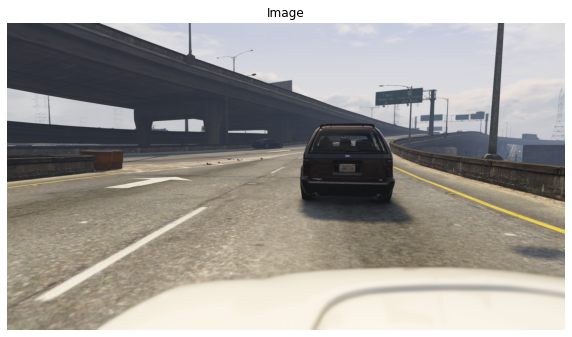

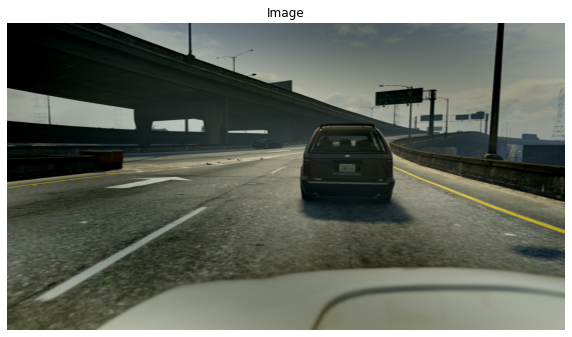

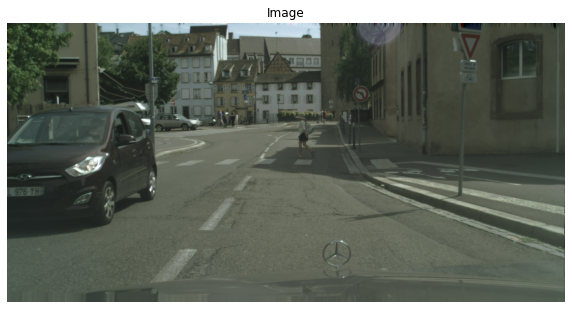

In [ ]:
id_client = 1
transform = None #Resize((512,1024))
train_dataset = ClientCityscapesPartA(root=ROOT_DIR, uniform = True, id_client = id_client, transform=transform, cl19 = True)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)

img_city = train_dataset[0]
print(img_city.shape)

SA = StyleAugment(n_images_per_style=20, L=0.01, size=(512, 1024), b=1) 
#L 0.01, 0.05, 0.09
# b == 0 --> 1x1, b == 1 --> 3x3, b == 2 --> 5x5, ...'
# #style = SA._extract_style(img)
SA.add_style(train_dataset, multiple_styles=False, name=None)

train_datasetgta5 = GTA5(root=ROOT_DIR_GTA5, transform=transform, cl19 = True, target_dataset='cityscapes')

img_GTA = train_datasetgta5[20]
print(img_GTA.shape)

figure = plt.figure(figsize=(10,20))
# plt.imshow(img_GTA.permute((1, 2, 0)).squeeze())
plt.imshow(img_GTA)
plt.axis('off')
plt.title("Image")
plt.show()


train_datasetgta5.set_style_tf_fn(SA.apply_style)

img_GTA = train_datasetgta5[20]
# transf = T.ToTensor()
# img_GTA = transf(img_GTA)
#print(img_GTA.shape)

figure = plt.figure(figsize=(10,20))
# plt.imshow(img_GTA.permute((1, 2, 0)).squeeze())
plt.imshow(img_GTA)
plt.axis('off')
plt.title("Image")
plt.show()

figure = plt.figure(figsize=(10,20))
# plt.imshow(img_GTA.permute((1, 2, 0)).squeeze())
plt.imshow(img_city)
plt.axis('off')
plt.title("Image")
plt.show()

In [ ]:
import cv2

img = read_image(os.path.join(ROOT_DIR,'images','strasbourg_000000_017593_leftImg8bit.png'))
print(type(img))
print(img.shape)
print(img[0][0][0])
transform_PIL = T.ToPILImage()
img = transform_PIL(img)
# img_np = np.array(img.permute(1,2,0))
print(type(img))
img_np = np.array(img)
print(img_np.shape)
print(img_np[0][0][0])

img = cv2.imread(os.path.join(ROOT_DIR,'images','strasbourg_000000_017593_leftImg8bit.png'), cv2.IMREAD_UNCHANGED)
print(type(img))
print(img.shape)
print(img[0][0][0])


img = Image.open(os.path.join(ROOT_DIR,'images','strasbourg_000000_017593_leftImg8bit.png'))
print(type(img))
img_np = np.array(img)
print(img_np.shape)
print(img_np[0][0][0])

<class 'torch.Tensor'>
torch.Size([3, 1024, 2048])
tensor(132, dtype=torch.uint8)
<class 'PIL.Image.Image'>
(1024, 2048, 3)
132
<class 'numpy.ndarray'>
(1024, 2048, 3)
135
<class 'PIL.PngImagePlugin.PngImageFile'>
(1024, 2048, 3)
132


### Training

In [ ]:
transform = Resize((512,1024))
random.seed(SEED)
if SPLIT == 1:
    client_type = True
elif SPLIT == 2:
    client_type = False

if FDA:
  ## TODO
  #clients = [_ in range(N_STYLES)]
  #clients = random.sample([_ for _ in range(TOT_CLIENT)],N_STYLE)
  
  clients = [0]#, 4, 5, 7, 8, 10, 13] # pick some clients
  SA = StyleAugment(n_images_per_style=MAX_SAMPLE_PER_CLIENT, L=0.1, size=(512, 1024), b=BETA) 
  if PARTITION == 'A':
    for c in clients:
      cityscapes_dataset = ClientCityscapesPartA(root=ROOT_DIR, uniform = client_type, id_client = c, transform=transform, cl19 = cl19)
      #cityscapes_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
      SA.add_style(cityscapes_dataset, multiple_styles=False, name=None)
  elif PARTITION == 'B':
    for c in clients:
      cityscapes_dataset = ClientCityscapesPartB(root=ROOT_DIR, uniform = client_type, id_client = c, transform=transform, cl19 = cl19)
      #cityscapes_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
      SA.add_style(cityscapes_dataset, multiple_styles=False, name=None)
  else:
    print("error")
    

100%|██████████| 16/16 [00:02<00:00,  6.00it/s]


In [ ]:
train_dataset_gta5 = GTA5(root=ROOT_DIR_GTA5, transform=transform, cl19 = cl19, target_dataset='cityscapes', split='train')

val_dataset_gta5 = GTA5(root=ROOT_DIR_GTA5, transform=transform, cl19 = cl19, target_dataset='cityscapes', split='val')
#train_dataset_gta5,val_dataset_gta5 = train_test_split(dataset_gta5,test_size=0.33, random_state=SEED)
print('train dimension:',len(train_dataset_gta5),'val dimension:',len(val_dataset_gta5))

if FDA: 
  # apply Fuorier Transformation on each source image  
  train_dataset_gta5.set_style_tf_fn(SA.apply_style) 

train_gta5_dataloader = DataLoader(train_dataset_gta5, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True) 
val_gta5_dataloader = DataLoader(val_dataset_gta5, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
#print("Dataset dimension: ", len(train_dataset_gta5))

train dimension: 450 val dimension: 50


In [ ]:
model = BiSeNetV2(NUM_CLASSES, output_aux=False, pretrained=True)

criterion = nn.CrossEntropyLoss(ignore_index= 255) 
parameters_to_optimize = model.parameters()
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

In [ ]:
model = model.to(DEVICE)

#wandb.watch(model, log='all')

cudnn.benchmark # Calling this optimizes runtime

losses = []
losses_val = []
epochs = []


current_step = 0
# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
  print('Starting epoch {}/{}'.format(epoch+1, NUM_EPOCHS))
  epochs.append(epoch+1)


  # Iterate over the dataset
  
  for images, labels in train_gta5_dataloader:

    images = images.to(DEVICE, dtype=torch.float32)
    labels = labels.to(DEVICE, dtype=torch.long)
    #print("images:",images.shape,"labels:",labels.shape)
    
    model.train()
    optimizer.zero_grad() 

    predictions = model(images)
    #print("predictions:",predictions.shape,"labels:",labels.shape)
    loss = criterion(predictions, labels.squeeze())

  
    # Log loss
    if current_step % LOG_FREQUENCY == 0:
      miou = compute_moiu(net=model, val_dataloader=val_gta5_dataloader)
      print('Step {}, Loss {}, mIoU {}'.format(current_step, loss.item(),miou))
      # wandb.log({
      #     "train/loss": loss,
      #     "train/miou":miou,
      #            })

    loss.backward()  
    optimizer.step()

    current_step += 1
  # save model checkpoint   
  if epoch % CHECKPOINT_LOG == 0:
    torch.save({
            'epoch': NUM_EPOCHS,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, CHECKPOINT_PATH+f"{epoch}_l{loss}.pt")


Starting epoch 1/10
Step 0, Loss 3.4046432971954346, mIoU 0.012212909758090973
Step 20, Loss 1.1481760740280151, mIoU 0.025009954969088238
Step 40, Loss 0.8876909613609314, mIoU 0.020525969564914703
Starting epoch 2/10
Step 60, Loss 0.9079691767692566, mIoU 0.01641376440723737
Step 80, Loss 0.5511316061019897, mIoU 0.01979752133289973
Step 100, Loss 0.7354865074157715, mIoU 0.01781926428278287
Starting epoch 3/10


KeyboardInterrupt: ignored

In [ ]:
val_dataset = CityscapesPartA(root=ROOT_DIR, train=False, transform=transform,cl19 = True)
print("Dataset dimension: ", len(val_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)

Dataset dimension:  42


In [ ]:
miou = compute_moiu(net=model, val_dataloader=val_dataloader)
print('Validation MIoU: {}'.format(miou))
# wandb.log({"val/miou":miou})

# wandb.finish()

Validation MIoU: 0.011855189502239228
